# Case_study_6_1

Let us assume the general problem in the most general formulation
form
$$\min_{{\bf{x}}} \frac{1}{n}\left\Vert {\bf{A}}{\bf{x}}-{\bf{b}}\right\Vert _{2}^{2}+\frac{\lambda}{2}\left\Vert {\bf{x}}\right\Vert _{2}^{2}$$

The gradient becomes:
$$
\frac{2}{n}{\bf{A}}_{(:,i)}^{T}({\bf{A}}_{(:,i)}{\bf{x}}^{i}+A_{(:,-i)}{\bf{x}}_{k}^{-i}-b)+\lambda {\bf{x}}^{i}=0
$$
and the closed form solution for BCD into:
$$
{\bf{x}}_{k+1}^{i}=({\bf{A}}_{(:,i)}^{T}{\bf{A}}_{(:,i)}+\frac{n}{2}\lambda {\bf{I}}_{m_{i}})^{-1}A_{(:,i)}^{T}(b-A_{(:,-i)}{\bf{x}}_{k}^{-i})
$$
where $\textrm{I}_{m_{i}}$ is the identity matrix with size $m_{i}\times m_{i}$.


In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
from local.lib.utils import solver_cvx, grad_FOM, grad_SOM, bcd_ridge, eval_loss, plot_surface
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

In [2]:
# Loading scenarios
# ===========================
scenario=4
data_reg, set_up=scenarios_regression(scenario);

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L2 = lambda w: cp.pnorm(w, p=2)**2

loss_LS_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)
grad_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@(X @ w - Y) + lambd * w
Hess_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@X + lambd * np.eye(X.shape[1])



# Different ways to solve theoreticaly the LS
#=========================================
# Solution of the empirical risk using CVX

w_L2_cvx=solver_cvx(set_up,loss_LS_L2);

Xtrain = set_up['Xtrain'][:,:set_up['d']+1]
w_opt=np.linalg.inv(2/set_up['Niter_train']*Xtrain.T@Xtrain + set_up['Lambda']*np.eye(set_up['d']+1))@((2/set_up['Niter_train'])*Xtrain.T)@set_up['ytrain'][:,0];

w = cp.Variable(w_L2_cvx.shape[0])
w.value = w_L2_cvx
loss_opt=loss_LS_L2(set_up['Niter_train'],set_up['Xtrain'][:,0:set_up['d']+1],set_up['ytrain'][:,0],w_L2_cvx,set_up['Lambda']).value
print(w_L2_cvx, w_opt)

          
# Gradient descent
out_gd = grad_FOM(set_up,grad_LS_L2)
loss_grad=eval_loss(out_gd,set_up,loss_LS_L2)

# Newton algorithm
out_hess =grad_SOM(set_up,grad_LS_L2,Hess_LS_L2)
loss_hess=eval_loss(out_hess,set_up,loss_LS_L2)

# FLEXA algorithm
out_bcd =bcd_ridge(set_up)
out_bcd2=np.c_[out_bcd[:,1:set_up['Number_iter_BCD']],np.kron(out_bcd[:,set_up['Number_iter_BCD']].reshape(-1,1),np.ones((1,set_up['Niter_train']-set_up['Number_iter_BCD']+1)))]
loss_bcd=eval_loss(out_bcd2,set_up,loss_LS_L2)


[ 0.323985    0.77237312 -0.18933215 -0.33565562 -0.50754327  0.22521081
  0.09893948 -0.09008726 -0.94323669 -1.09015215 -0.03973205 -0.50413416] [ 0.32408307  0.77252549 -0.18933483 -0.3357633  -0.50769306  0.2252318
  0.09899053 -0.09016374 -0.94348757 -1.09049868 -0.03978846 -0.50429946]


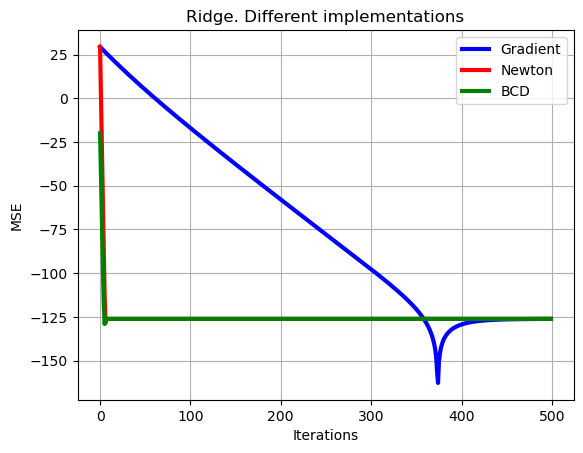

In [3]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_grad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_hess-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_bcd-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='g', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(['Gradient','Newton','BCD'])
plt.title('Ridge. Different implementations')
plt.show()

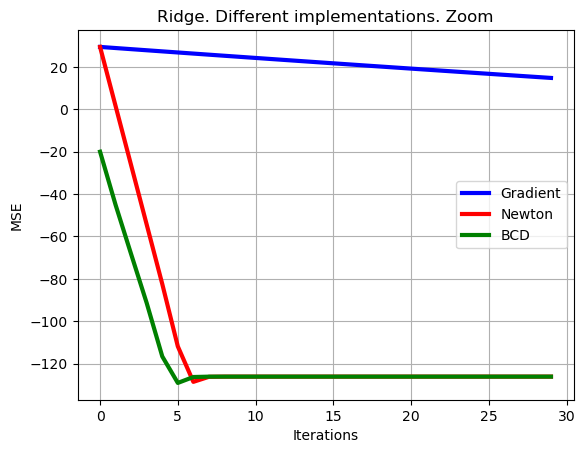

In [4]:
# Let's make a zoom
# Plot of learning curves
show=30
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_grad[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='b', linewidth = 3)
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_hess[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='r', linewidth = 3)
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_bcd[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='g', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(['Gradient','Newton','BCD'])
plt.title('Ridge. Different implementations. Zoom')
plt.show()